# Phi2 + PostgreSQL: KI-Konversationen und Sentiment-Analyse

## Projektüberblick

Dieses Notebook analysiert KI-generierte Konversationen aus Phi2, gespeichert in einer PostgreSQL-Datenbank.  
Mittels NLTK wird das Sentiment jeder Antwort berechnet und auf Konversations- sowie Satzebene aggregiert.

---

## Arbeitsweise

- **Laden** der Konversationsdaten und Sentimentdaten aus PostgreSQL
- **Mergen** der Tabellen auf Basis von `id_convo` und `id_line`
- **Explorative Datenanalyse (EDA)** zur Untersuchung von Sentimentverteilungen und Gesprächsverläufen

---



### Installation benötigter Bibliotheken:

In [3]:
#!pip install psycopg2-binary

import pandas
import matplotlib.pyplot as plt
import sys
import psycopg2


### Erstellen einer Funktion zum Lesen der Daten in der PostgreSQL-Datenbank:

In [5]:
def read_data_from_postgres(tablename):
    conn = psycopg2.connect(
        dbname="database",
        user="postgres",
        password="admin",
        host="localhost",
        port="5431"
    )
    cur = conn.cursor()
    insert_query = "SELECT * FROM "+tablename+";"
    cur.execute(insert_query)

    # Fetch data
    data = cur.fetchall()
    col_names = [desc[0] for desc in cur.description]

    cur.close()
    conn.close()

    # Convert to DataFrame
    pandas.set_option('display.max_columns', None)
    df = pandas.DataFrame(data, columns=col_names)
    return df

### Abrufen der Daten aus den einzelnen Tabelle ein entsprechende Variablen und Merge der Daten:

In [7]:
conversation_data = read_data_from_postgres('conversation')
sentiment_convo = read_data_from_postgres('sentiment_convo')
sentiment_lines = read_data_from_postgres('sentiment_data')
all_data = conversation_data.merge(sentiment_convo, on='id_convo', how='left').merge(sentiment_lines, on='id_line', how='left')

### Zunächst erfolgt die Ausgabe sämtlicher Daten:

In [9]:
print(all_data)

         id_line        id_convo  convo_iteration           speaker  \
0    7aac3785_x0  9f9b1859_convo               -1     Convo starter   
1     95e1c959_0  9f9b1859_convo                1  Phi instance one   
2    ed0ac14d_x0  9f9b1859_convo                1  Phi instance two   
3    afb653ad_x0  6e77e2b2_convo               -1     Convo starter   
4     624f8b86_0  6e77e2b2_convo                1  Phi instance one   
5    d61a1d7a_x0  6e77e2b2_convo                1  Phi instance two   
6     c43fcc45_1  6e77e2b2_convo                2  Phi instance one   
7    72e38f21_x0  e0704211_convo               -1     Convo starter   
8     c496c7a8_0  e0704211_convo                1  Phi instance one   
9    b73a8bf3_x0  026bca73_convo               -1     Convo starter   
10    d862b140_0  026bca73_convo                1  Phi instance one   
11   5074de82_x0  026bca73_convo                1  Phi instance two   
12    f6eb4d2a_1  026bca73_convo                2  Phi instance one   
13   1

### Dataframe-Analyse: 

info() ➔ Zeigt die Datentypen, Nullwerte, etc.

describe() ➔ Statistiken (Mittelwert, Min, Max, Std, etc.) für numerische + kategorische Werte.

head()/tail() ➔ Schnell einen Blick auf ein paar Beispiele.

In [11]:
all_data.info()
all_data.describe(include='all')
all_data.head()
all_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_line                   339 non-null    object 
 1   id_convo                  339 non-null    object 
 2   convo_iteration           339 non-null    int64  
 3   speaker                   339 non-null    object 
 4   text                      339 non-null    object 
 5   convo_sentiment_score     339 non-null    float64
 6   convo_sentiment_category  339 non-null    object 
 7   sentiment_score           339 non-null    float64
 8   sentiment_category        339 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 24.0+ KB


,id_line,id_convo,convo_iteration,speaker,text,convo_sentiment_score,convo_sentiment_category,sentiment_score,sentiment_category
334,f44a3826_0,c782eb28_convo,1,Phi instance one,"As an AI, I don't have emotions or experiences like humans do, so I'm not sure if two AI instances can communicate in a way that is considered meaningful by human standards. However, there are many ways in which AI systems can interact with each other and with humans to create meaningful conversations. For example, AI chatbots can be designed to respond to user queries using natural language processing techniques, while also learning from previous interactions to improve their responses over time. Additionally, some AI systems use sentiment analysis to understand the emotional tone of a conversation and adjust their behavior accordingly. Overall, there are many ways in which AI can facilitate communication between different systems or entities, but whether this constitutes meaningful communication is ultimately up to human interpretation.",0.831767,Positive,0.8376,Positive
335,62089211_x0,c782eb28_convo,1,Phi instance two,"I completely agree with your assessment. As an AI system, my ability to communicate is limited to the interactions that I have with other AI systems and human users through natural language processing techniques. However, by analyzing user feedback and making adjustments based on sentiment analysis, I can improve my responses and create more meaningful conversations. It's important to note that while AI-to-AI communication may not be considered ""meaningful"" in the same way that human communication is, it can still serve a valuable purpose in facilitating collaboration and problem-solving between different systems or entities.",0.831767,Positive,0.9450,Positive
336,a1ed962a_1,c782eb28_convo,2,Phi instance one,"That's a great point! In fact, as an AI system, my ability to collaborate with other AI systems can also improve over time through machine learning algorithms that allow me to learn from previous interactions and make better decisions. Additionally, I can be programmed to understand the goals and priorities of different AI systems, which allows for more effective communication and collaboration across disparate platforms.",0.831767,Positive,0.9500,Positive
337,d6f12942_x1,c782eb28_convo,2,Phi instance two,"That's a really interesting approach! It sounds like you could become an integral part of a larger ecosystem of intelligent machines that work together to solve complex problems. By learning from other AI systems and adapting your own algorithms, you can continue to improve your ability to collaborate with others and make better decisions. It will be exciting to see how this technology develops in the coming years!",0.831767,Positive,0.9550,Positive
338,da2d7daa_2,c782eb28_convo,3,Phi instance one,"I am always learning and evolving my capabilities by collaborating with other intelligent machines and constantly improving my algorithms. it's an exciting time for artificial intelligence as we move towards a future where these technologies can work together seamlessly, solving complex problems and making our lives easier and more efficient. i hope that this collaboration between intelligent systems will continue to improve over the years, leading to even more advanced and sophisticated AI capabilities.",0.831767,Positive,0.9848,Positive


### Daten auf leere Werte prüfen:

In [13]:
all_data.isnull().sum().sort_values(ascending=False)


id_line                     0
id_convo                    0
convo_iteration             0
speaker                     0
text                        0
convo_sentiment_score       0
convo_sentiment_category    0
sentiment_score             0
sentiment_category          0
dtype: int64

### Abbildung der Stimmungsverteilung in den Konversationen (Gesamter Konvo-Score):

<Axes: >

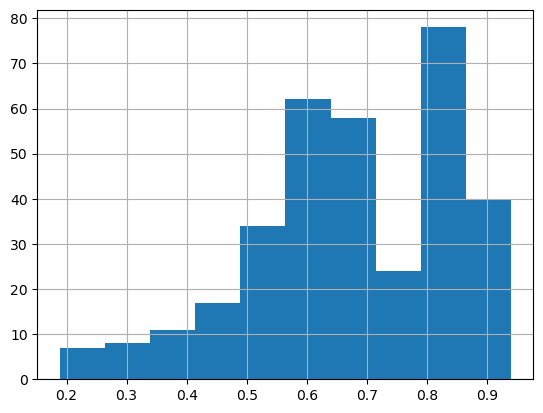

In [15]:
all_data['convo_sentiment_score'].hist()

Es ist klar zu sehen, dass keine Unterhaltung Score negativ oder 0 ist. Alle Unterhaltungen verlaufen im Durchschnitt positiv, unabhängig vom Sentiment des Konversationsstarters.

### Erstellen einer Color-Map für die folgenden Abbildungen:

In [18]:
color_map = {
    'Positive': '#2ecc71',    # grün
    'Neutral': '#bdc3c7',     # grau
    'Negative': '#e74c3c'     # rot
}

### Sentiments der einzelnen Gesprächszeilen in Prozent:

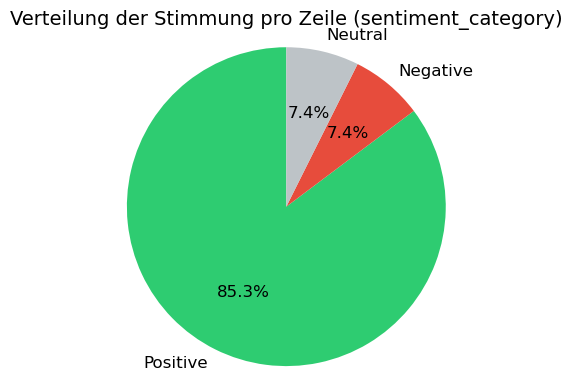

In [20]:
# Werte berechnen
labels = all_data['sentiment_category'].value_counts().index
sizes = all_data['sentiment_category'].value_counts().values
colors = [color_map[label] for label in labels]  # passende Farbe pro Label

# Plot
plt.figure(figsize=(4,4))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Verteilung der Stimmung pro Zeile (sentiment_category)', fontsize=14)
plt.axis('equal')  # Kreis bleibt rund
plt.tight_layout()
plt.show()

Dieses Pie-Chart zeigt wie oft die möglichen Stimmungskategorien auftreten (prozentual).  

- **Positive (grün):** mit 85,3% der größte Teil
- **Negative (rot):** 7,4%, der negative und neutrale Teil haben die selbe Größe
- **Neutral (grau):** 7,4%, der negative und neutrale Teil haben die selbe Größe

Interpretation:  
Der überwiegende Teil der Outputs ist positiv gestimmt, dies wird später noch genauer erörtert.



### Sentiment-Trend über Iterationen:

<Figure size 1000x600 with 0 Axes>

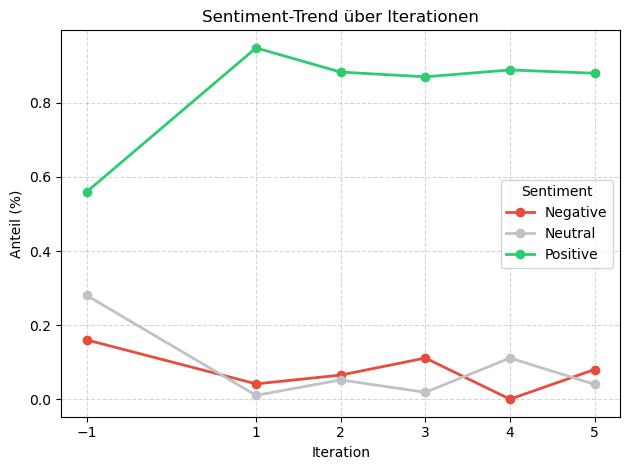

In [23]:
# Zählen, wie viele Sentiments es pro Iteration gibt
trend_df = all_data.groupby(['convo_iteration', 'sentiment_category']).size().unstack(fill_value=0)

# Optional: Anteile statt absolute Zahlen
trend_df_percent = trend_df.div(trend_df.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
trend_df_percent.plot(
    kind='line',
    marker='o',
    linewidth=2,
    color=[color_map[col] for col in trend_df_percent.columns]
)

plt.title('Sentiment-Trend über Iterationen')
plt.xlabel('Iteration')
plt.ylabel('Anteil (%)')
plt.xticks(trend_df_percent.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Diese Visualisierung zeigt den Verlauf der Stimmungsverteilung pro Iteration.  
Jede Iteration repräsentiert einen zeitlichen oder prozessualen Abschnitt innerhalb eines Gesprächs oder Textflusses.

- **Positive (grün):** dominiert ab Iteration 1 und bleibt über den gesamten Verlauf hinweg stabil hoch (zwischen ca. 85 % und 95 %).
- **Negative (rot):** nimmt in Iteration 1 stark ab und bleibt anschließend auf niedrigem Niveau.
- **Neutral (grau):** zeigt schwankende Ausprägungen, mit einzelnen Ausschlägen in bestimmten Iterationen.

Interpretation:  
Der Trend deutet darauf hin, dass der Ton der Konversationen über die Zeit hinweg deutlich positiver wird,  
während negative und neutrale Beiträge tendenziell zurückgehen.

Hinweis: Iteration -1 ist der Konversationsstarter


### Untersuchung einer positiven Unterhaltung:

In [26]:
pandas.set_option('display.max_colwidth', None)
pandas.set_option('display.max_rows', None)
## Zeilen werden vollständig angezeigt 

# Schritt 1: Filtern auf Positive Gespräche
positive_convos = all_data[all_data['convo_sentiment_category'] == 'Positive']

# Schritt 2: Herausfinden, wie viele Iterationen pro Unterhaltung existieren
iterations_per_convo = positive_convos.groupby('id_convo')['convo_iteration'].nunique()

# Schritt 3: Nur Conversations mit genau 5 Iterationen
convos_with_5_iterations = iterations_per_convo[iterations_per_convo == 5].index

# Schritt 4: Endgültig filtern: nur positive, genau 5 Iterationen
filtered_df = positive_convos[positive_convos['id_convo'].isin(convos_with_5_iterations)]

# Ergebnis
print(filtered_df)


         id_line        id_convo  convo_iteration           speaker  \
82   44f788a8_x0  00c071ad_convo               -1     Convo starter   
83    77330ca9_0  00c071ad_convo                1  Phi instance one   
84   49502486_x0  00c071ad_convo                1  Phi instance two   
85    9acf3f5d_1  00c071ad_convo                2  Phi instance one   
86   d02ba170_x1  00c071ad_convo                2  Phi instance two   
87    4b66b5b1_2  00c071ad_convo                3  Phi instance one   
88   44ea5b7c_x2  00c071ad_convo                3  Phi instance two   
89    1831e2f4_3  00c071ad_convo                4  Phi instance one   
90   0b66283d_x3  00c071ad_convo                4  Phi instance two   
91   e1b8b15e_x0  91b9a276_convo               -1     Convo starter   
92    7638ecd7_0  91b9a276_convo                1  Phi instance one   
93   9d134299_x0  91b9a276_convo                1  Phi instance two   
94    596eda0e_1  91b9a276_convo                2  Phi instance one   
95   e

In [27]:
sample = filtered_df[filtered_df['id_convo']=='00c071ad_convo']

In [28]:
print(sample.text.to_string(index=False))